Following from my [previous post](/posts/data_preparation/fetch-lastfm.qmd) on fetching my Last.fm scrobbles (check it out here
if you want to see how I did it), I now have more than ten years' worth of data and no idea what to do with it. 

My first thought was to visualize my top artists, so I decided to experiment a
bit with how I could do that. I recently found a very nice website (aptly) 
named [The Python Graph Gallery](https://python-graph-gallery.com), which has 
a lot of interesting examples of how to visualize data using Python. 

Out of all the examples, there were a couple I found particularly interesting, 
so I decided to apply them to my own data. However, before getting to that 
point, I had to do a lot of data wrangling to get my data into the proper format. 

This was all done using Python and the Polars library, so if you're not interested
in the plots but are curious to see some funky Polars code, do keep reading.

## Preparing the data
First, I imported the various libraries I needed:
- `datetime` was needed for some datetime manipulation.
- `matplotlib` because I wanted to push it further than I usually do.
- `polars` for all data manipulation.
- `skrub` for some cleaning and for the `TableReport` (also, it's the library I work on).
- `scipy.ndimage` for data smoothing to make the first plot prettier.

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from skrub import Cleaner, TableReport
from scipy.ndimage import gaussian_filter1d

First, I read the data from the CSV file I generated in the previous post, then
I pass it to the `Cleaner` class from `skrub` to clean it up a bit.

Starting from skrub version 0.6.0, the `Cleaner` has the `datetime_format` argument,
which I am using here to parse directly the timestamp without having to use polars. 

Then, I use the `TableReport` to look at the data and see what it looks like.

In [2]:
df = pl.read_csv("data/recent-tracks.csv")
cleaner = Cleaner()
df = Cleaner(datetime_format="%d %b %Y, %H:%M").fit_transform(df)
TableReport(df, verbose=0)

,,,,,,,


The `TableReport` is a pretty neat tool with a lot of features. In this case, I 
was particularly interested in the `Stats` tab, which shows various high-level
statistics about each column in the table. Here, it immediately showed me that 
some columns include a lot of missing values: the `artist_mbid` column has 
about 24% missing values, while both the `album_mbid` and `track_mbid` columns
have more than 40% missing values. 

What's the `mbid`? It's the [MusicBrainz Identifier](https://musicbrainz.org/doc/MusicBrainz_Identifier), 
a unique identifier for each artist, album, and track in the MusicBrainz database.

Why does it matter? Because it allows me to link artists and tracks with the 
MusicBrainz database, which contains additional information about them, such 
as the genre, the release date, the country of origin, and so on. 
In other words, missing the `mbid` means I am missing out on a lot of additional
information that I could use for new plots. This is a shame, and I already have
plans on how to fix this. 

In this post, however, I will focus on the artists, the tracks, and the 
timestamps of the scrobbles to take a look at the evolution of my favorite artists 
over the years. 
Originally, I wanted to include the genres as well, as they have a larger 
granularity and would therefore be easier to visualize, but the data dump I 
have does not include them, and even querying the Last.fm API did not help with 
filling in the gaps for most of the less popular artists in my library.

In any case, lets move on to the actual data wrangling. 

## Finding the top artists 

I decided to extract the top 15 artists from the data based on the number of scrobbles
to have some variety, while remaining able to plot all of them at the same time. 
I also want to treat them separately from all the other artists:
this comes into play later for the stackplot. 

In [3]:
top_k = 15
top_artists = (
    df.group_by("artist") # group by artist
    .agg(pl.len().alias("count")) # count the number of scrobbles per artist
    .top_k(k=top_k, by="count") # get the top k artists
)
top_artists

artist,count
str,u32
"""Muse""",11017
"""Coldplay""",5470
"""Jovanotti""",5444
"""Negrita""",4767
"""Zucchero""",3879
…,…
"""Daft Punk""",1479
"""Avicii""",1470
"""U2""",1276


Now for the nasty wrangling part. Since my objective is to visualize the evolution
of my favorite artists over time, I can do this by counting the number of scrobbles
per artist each month. 

However, what I want from my stackplot is to show how many
of the scrobbles in each month come from one of the top 15 artists, and how many
come from the rest. For this, I need to find the _fraction_ of scrobbles per month
per artist. To avoid skewing the results in months where I listened to very few
of the top artists, I will also include the total number of scrobbles for 
"everyone else" in the fraction.

In [16]:
df_prep = (
    df.with_columns(
        pl.when(pl.col("artist").is_in(top_artists["artist"])) # check if artist is in top artists
        .then(pl.col("artist")) # keep the artist name
        .otherwise(pl.lit("Everyone else")) # otherwise label as "Everyone else"
        .alias("artist") # replace the artist column with this new one
    )
)

Now that I have the top artists and "everyone else", I can count the number of 
scrobbles per artist each month. For this, I first select only the artist and the
timestamp columns, then I truncate the timestamp to the month, and finally I 
group the data by artist and month, counting the number of scrobbles for each
group, i.e., for each artist in each month.

In [17]:
df_prep = (df_prep
    .select( 
        [
            pl.col("artist"),
            pl.col("utc_time").dt.truncate("1mo"), # truncate the time to the month
        ]
    )
    .group_by(["artist", "utc_time"])
    .agg(count=pl.len())
    .sort(["utc_time", "count"])
)
df_prep

artist,utc_time,count
str,datetime[μs],u32
"""Mika""",2012-12-01 00:00:00,1
"""U2""",2012-12-01 00:00:00,1
"""Caparezza""",2012-12-01 00:00:00,2
"""Zucchero""",2012-12-01 00:00:00,13
"""Negrita""",2012-12-01 00:00:00,15
…,…,…
"""Hoshimachi Suisei""",2025-04-01 00:00:00,53
"""Coldplay""",2025-04-01 00:00:00,73
"""Negrita""",2025-04-01 00:00:00,81


Each row in `df_prep` now contains the artist name, the month of the scrobble, 
and the number of scrobbles for that artist in that month. 

Now, I want to calculate the fraction of scrobbles per artist each month, that is,
how many of the scrobbles for a given month were made with the specific artist:
this is what I want to put in the stackplot. Will it be a good choice? Looking back,
it probably wasn't. 

In any case, for this I need to group the data
by month to find the total number of scrobbles for each month, then add a new 
column where I store the fraction. 

In [18]:
df_prep = df_prep.join( 
        df_prep # self-join to add the total number of scrobbles per month
        .group_by("utc_time") # group by month
        .agg(pl.sum("count").alias("total_scrobbles")), # total number of scrobbles per month
        on="utc_time" 
    ).with_columns(
        frac=pl.col("count") / pl.col("total_scrobbles") * 100 # calculate the fraction 
)
df_prep

In [19]:
df_prep

artist,utc_time,count,total_scrobbles,frac
str,datetime[μs],u32,u32,f64
"""Mika""",2012-12-01 00:00:00,1,334,0.299401
"""U2""",2012-12-01 00:00:00,1,334,0.299401
"""Caparezza""",2012-12-01 00:00:00,2,334,0.598802
"""Zucchero""",2012-12-01 00:00:00,13,334,3.892216
"""Negrita""",2012-12-01 00:00:00,15,334,4.491018
…,…,…,…,…
"""Hoshimachi Suisei""",2025-04-01 00:00:00,53,405,13.08642
"""Coldplay""",2025-04-01 00:00:00,73,405,18.024691
"""Negrita""",2025-04-01 00:00:00,81,405,20.0


Now I have a dataframe that contains all the information I need: for each month,
I have the artists I listened to, the number of songs played, the number of total
scrobbles in that month, and finally the fraction of scrobbles for each artist. 

### Getting a fixed order for my top artists 
A small detail I wanted to get done was getting a fixed order for my artists, 
with the "Everyone else" label on top. This is easy to do: 

In [20]:
ranking = df_prep.group_by("artist").agg(pl.sum("count")).sort("count", descending=True)
order = ranking["artist"].to_list()
order

Now for the final, and possibly worst part of the entire preparation: massaging 
the data into a format that _should_ be easier to plot iteratively with the stackplot.

The rough idea is having a dictionary where each key is one of the top artists,
and each artist is mapped to a list of values for each month (including the months
in which I did not listen to them); then, plotting each artist separately becomes
easier. Getting there, however, is anything but. 

### Which artists am I always listening to? 
The main problem here is that no artist (other than the "Everyone else" label) 
was played every month since the start of the data collection: 

In [26]:
df_prep.select("artist", "utc_time").group_by("artist").agg(pl.len().alias("Months played")).sort("Months played", descending=True)

artist,Months played
str,u32
"""Everyone else""",145
"""Muse""",134
"""Coldplay""",128
"""Jovanotti""",122
"""Negrita""",119
…,…
"""Daft Punk""",76
"""Mika""",43
"""Hoshimachi Suisei""",27


So at the top we have Muse, Coldplay, Jovanotti and Negrita that showed up almost 
every month; even they, however, are missing for about one year throughout. 

At the other end of the ladder sit Hoshimachi Suisei, Ado and YOASOBI, three Japanese
singers that I discovered about two years ago, and that have been a staple of my
playlists ever since. They'll get their own post in due time. 

Closing this small parenthesis to explain why there are a bunch of missing values,
how did I deal with them? 

First off, I defined a datetime range that started on the first month of data,
and that finished at the end of the data range, with a point every month. 

In [9]:
all_time = pl.DataFrame(
    {
        "time": pl.datetime_range(
            start=datetime(2012, 12, 1),
            end=datetime(2025, 4, 20),
            interval="1mo",
            eager=True,
        )
    }
)

# Defining the dictionaries to hold the data for the plot
dict_frac = {}
dict_abs = {}
dict_cumulative = {}
labels = []


Now the fun part. I group again by artist, and _right join_ on the `all_time` range 
defined above. The result is having a new `group` that has a line for every month
in the range, and null values on all rows where the artist is missing. 

Then, I fill in the null values with 0's (I could also fill in the artist name,
but I'm not using it here).

I then fill each dictionary with a numpy array taken from each column, and 
conclude by sorting the dictionaries according to the `order` of artists defined
before. 

In [29]:
for gidx, g in df_prep.group_by("artist"):
    group = (
        g.with_columns(pl.col("utc_time").dt.truncate("1mo"))
        .join(all_time, left_on="utc_time", right_on="time", how="right")
        .with_columns(pl.col("frac").fill_null(0), pl.col("count").fill_null(0))
    )

    dict_frac[gidx[0]] = group["frac"].to_numpy()
    dict_abs[gidx[0]] = group["count"].to_numpy()
    dict_cumulative[gidx[0]] = group["count"].to_numpy()
    labels.append(gidx[0])

dict_frac = {k: dict_frac[k] for k in order}
dict_abs = {k: dict_abs[k] for k in order}
dict_cumulative = {k: dict_cumulative[k] for k in order}
dict_total = dict(ranking.rows())

Whew. This was not pretty, but one of the positives of this approach is that now
I have, for each of the top artists, three things I can play with, and plot:
- for each month, the number of songs played 
- how much of my listening was monopolized by the artist
- the cumulative number of scrobbles, showing me the evolution month by month

This is a lot of information! In the next section, I'll use the first and second 
points, and in later posts I'll explore the third. 

## Plotting the data
As explained just above, it's time to put everything into
something that's "good to look at". Whether I pulled that off, I'll let the reader
decide. 

### First attempt: stackplot
To start with, let's try to prepare the stackplot without any smoothing. 

Text(0, 0.5, 'Percentage of total plays')

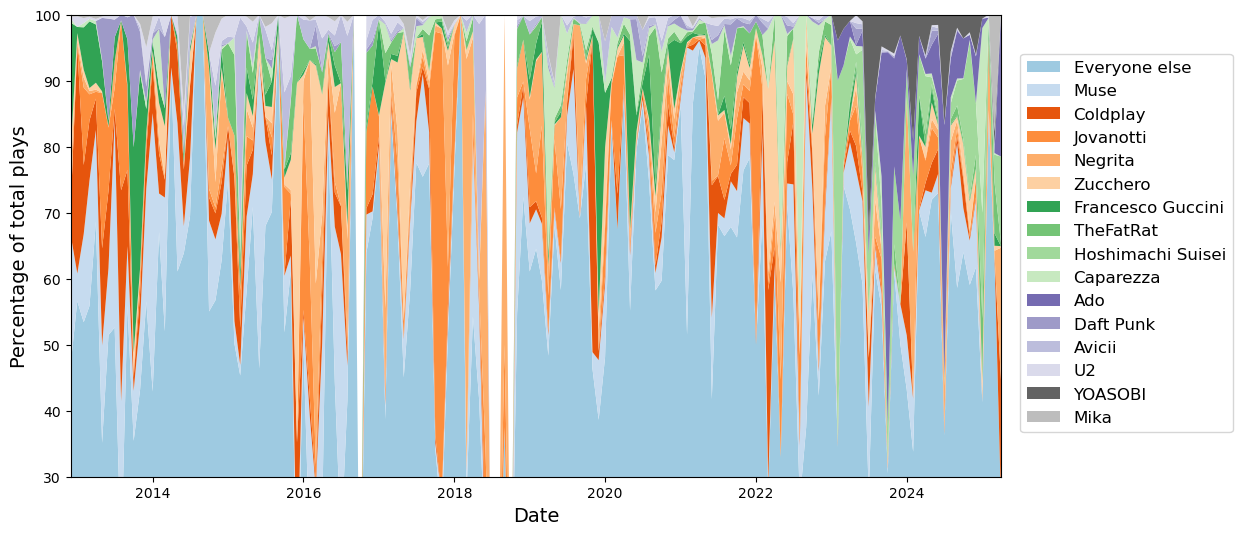

In [40]:
x = all_time["time"].to_numpy()
y = np.array(list(dict_frac.values()))
cmap = plt.cm.tab20c
colors = cmap(np.linspace(0.1, 0.9, len(order)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(
    x,
    y,
    labels=order,
    colors=colors,
)
fig.legend(loc="center right", ncol=1, fontsize=12, bbox_to_anchor=(1.1, 0.5))

ax.set_xlim(x[0], x[-1])
ax.set_ylim(30, 100)

ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Percentage of total plays", fontsize=14)

Oof. This does not look great. Better smooth it out. 

Note: unfortunately, I lost track of whatever source I used for preparing the following
snippet of code, but it definitely started in the [stackplot section](https://python-graph-gallery.com/streamchart/)
of the Graph Gallery linked before. 

The gist of it is adding a gaussian filter to the data, so that most of the 
jaggedness is removed. I'm also removing any month that has no data at all using 
a mask. 

In [41]:
x = all_time["time"].to_numpy()
y = np.array(list(dict_frac.values()))
sigma = 2
mask = ~(y.sum(axis=0) == 0)
y = y[:, mask]
x = x[mask]
y = gaussian_filter1d(y, sigma=sigma)

I define a specific colormap based on the artists:

In [42]:
cmap = plt.cm.tab20c
colors = cmap(np.linspace(0.1, 0.9, len(order)))

Now I can use the matplotlib `stackplot` function to finally draw my data. 
Some labels to make the data pretty, but nothing particularly fancy to add here. 

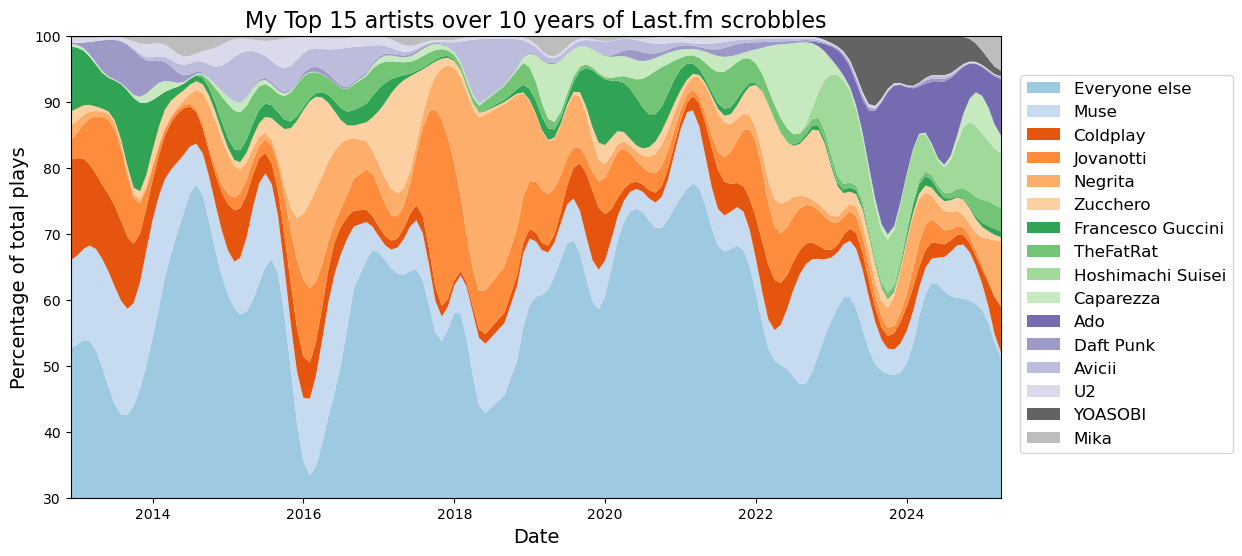

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(
    x,
    y,
    labels=order,
    colors=colors,
)
fig.legend(loc="center right", ncol=1, fontsize=12, bbox_to_anchor=(1.1, 0.5))

ax.set_xlim(x[0], x[-1])
ax.set_ylim(30, 100)

ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Percentage of total plays", fontsize=14)
ax.set_title(f"My Top {top_k} artists over 10 years of Last.fm scrobbles", fontsize=16)

To be honest, I am not satisfied with this plot at all. It's hard to read, the 
color palette is not clear and there isn't a clear pattern to it. For example, 
having a color that's related to the nationality of the artist would make it easier
to pick on patterns (shame that the nationality is not readily available from 
the last.fm data...).

The only thing that can somewhat be gleamed is that some of the artists are far
more consistent through the years, while others were more common at a certain 
point and then progressively fell off. Another thing that's pretty clear is that
a couple of years ago my tastes evolved pretty sharply, with Japanese singers
taking up a far larger fraction of everything I was listening to. 

Anyway, I am not happy with this plot, so I looked a bit more for alternatives
and landed on something that ended up being far more satisfying. 

### Second attempt: multiple line chart
The second plot was heavily inspired by [this plot](https://python-graph-gallery.com/web-small-multiple-with-highlights/) 
from the gallery. 

I really like that plot: it's informative and shows the information in an interesting
way. Moreover, I have never played around with facecolors and fonts, and that plot
inspired me to try something different from the usual "default font on white 
background". 

For this plot, I'm only interested in the actual artists, no need to have 
"Everyone else" in the way. 

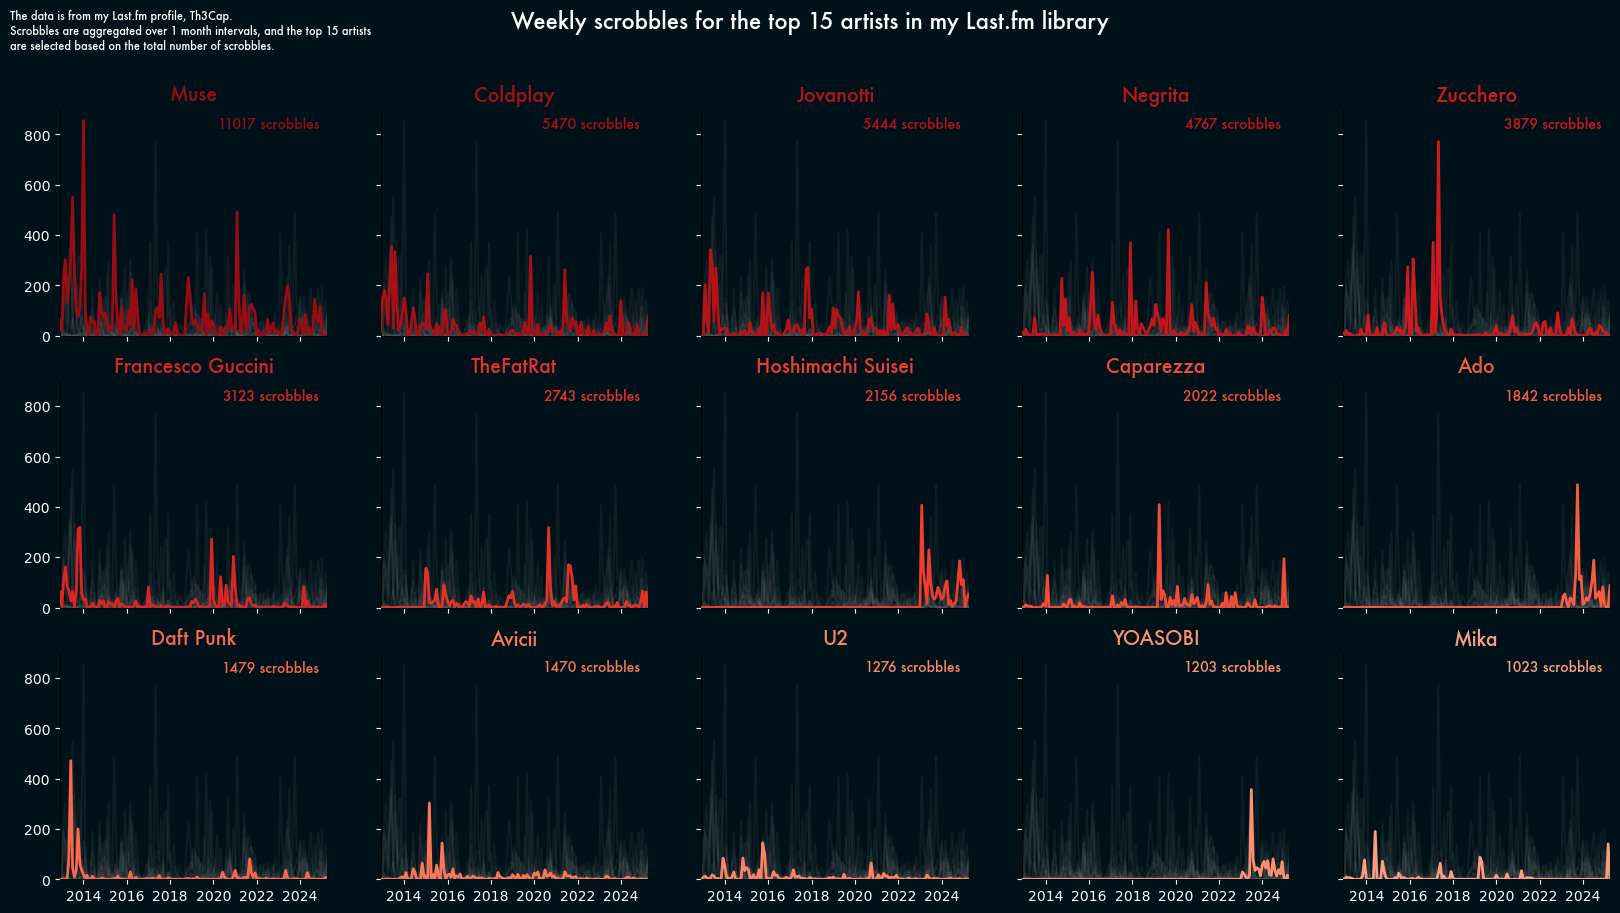

In [ ]:
# del dict_abs["Everyone else"]

# Defining a new colormap
cmap = plt.cm.Reds
colors = cmap(np.linspace(0.3, 0.9, len(order))[::-1])

# 15 subplots, one for each artist 
fig, axs = plt.subplots(3, 5, figsize=(20, 10), sharex=True, sharey=True)
# changing the background color
background_color = "#001219"
fig.set_facecolor(background_color)

# Plotting each artist in its own subplot
for i, (k, v) in enumerate(dict_abs.items()):
    # Each plot has its own color 
    color = colors[i]
    # Finding the right subplot
    ax = axs[i // 5, i % 5]
    # Setting the background color of each subplot (it's separate from the fig background)
    ax.set_facecolor(background_color)
    # reusing the same mask as before
    v = v[mask]
    
    # Plotting the current artist with the given artist 
    ax.plot(x, v, color=color, zorder=3, linewidth=2)
    # Here I can set the font 
    ax.set_title(f"{k}", color=color, fontsize=14, fontweight="bold", fontname="Futura")
    
    # fixing the x and y limits for the current subplot
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(0, 900)

    # changing the color of the axes to fit the dark background
    ax.tick_params(axis="x", colors="white")
    ax.tick_params(axis="y", colors="white")

    # removing the top and right spines    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adding the total number of scrobbles in the top right corner
    ax.text(
        0.97,
        0.97,
        f"{dict_total[k]} scrobbles",
        ha="right",
        va="top",
        fontsize=10,
        color=color,
        fontname="Futura",
        transform=ax.transAxes,
        )

    # Plotting the other artists in grey in the background
    for _k, v in dict_abs.items():
        if _k == k:
            continue
        v = v[mask]
        ax.plot(x, v, color="grey", alpha=0.1)

# Adding a main title and a description
fig.suptitle(
    "Weekly scrobbles for the top 15 artists in my Last.fm library",
    fontsize=16,
    color="white",
    fontname="Futura",
)

desc = """The data is from my Last.fm profile, Th3Cap. 
Scrobbles are aggregated over one month intervals, and the top 15 artists 
are selected based on the total number of scrobbles."""

fig.text(
    0.1,
    0.98,
    desc,
    ha="left",
    va="top",
    fontsize=8,
    color="white",
    fontname="Futura",
)

Now, this is a plot I am happy about. It might not be the most compact way to 
represent the data, but I don't necessarily care. I really like the "dark mode"
theme, I like the color map, and plotting the other artists in the background 
is a nice way to show indirectly how a specific artist compares to the competition
on a given month.

It's also interesting to see how some artists appear to be more consistent, while
some others are more likely to be a fad that I go back to after some time. 

## Conclusions
This post took forever and a half to write, in no small part because of how
disappointed I was in the stackplot and how annoying the data wrangling part was.

I am quite happy with the final plot, however, and at least now I have a way of 
representing the evolution of an artist over the years. I'm already working on 
another plot focusing specifically on Muse, and I hope I'll get that one out
much quicker than I did this.

In any case, thanks for sticking around until the end, and I hope you enjoyed the
journey and maybe learned something from it.